# Introduction to Machine Learning: End-Term Project

## Predicting the Sales Velocity of Men's Perfumes on eBay

*   **Team Members:** `Kemel Merey`, `Kuanyshbek Ulpan`, `Zholdybay Altynbek`
*   **Course:** Introduction to Machine Learning
*   **Date:** `11.12.2025`

---

### 1. Problem Definition

#### 1.1. Dataset Source and Context

The dataset for this project is a collection of men's perfume listings scraped from eBay, available on Kaggle: [Ebay Men's Perfume Dataset](https://www.kaggle.com/datasets/kanchana1990/perfume-e-commerce-dataset-2024). It contains approximately 1,000 unique listings, with features describing each product, its price, seller information, and sales history as of late May 2024.

In a competitive e-commerce marketplace like eBay, sellers constantly face key questions: Which products should I stock? How will a new listing perform? Understanding the factors that drive sales is crucial for inventory management, marketing strategy, and maximizing profitability. This project aims to use machine learning to unlock these insights from the provided data.

#### 1.2. The Prediction Task: From "How Many?" to "How Fast?"

Our primary objective is to build a regression model that predicts the **popularity or sales velocity** of a perfume listing.

Initially, one might consider the `sold` column as the direct target. However, this presents a significant challenge. The `sold` column is a cumulative count over the entire lifetime of the listing, which is an unknown duration. For example:
*   A listing with **100 units sold** over the course of a year is less popular than...
*   A new listing with **50 units sold** in its first week.

Simply predicting the raw `sold` count would be misleading. Instead, we will engineer a more meaningful target variable: **sales velocity**. We will define this as the average number of units sold per day. This normalizes the target and provides a true measure of a listing's current market demand.

> **Our Refined Problem Statement:**
> **To build a regression model that predicts the sales velocity (units sold per day) of a men's perfume listing on eBay, based on its characteristics such as brand, price, fragrance type, and seller location.**

*   **Target Variable (to be engineered):** `sales_velocity` (Regression)
*   **Features (Initial):** `brand`, `title`, `type`, `price`, `itemLocation`.

#### 1.3. Initial Hypotheses

Before diving into the data, we formulate several hypotheses that we will seek to validate during our Exploratory Data Analysis (EDA):

1.  **Price is King:** We hypothesize a strong, negative correlation between `price` and `sales_velocity`. Generally, cheaper items should sell faster, especially for common, non-luxury brands.
2.  **Brand Power:** We believe that well-known, high-demand brands (e.g., 'Dior', 'Versace') will maintain high sales velocity even at premium prices, while lesser-known or 'Unbranded' items will only sell quickly if priced very low.
3.  **Geographical Influence:** Does a seller's `itemLocation` impact sales volume? We will investigate if sellers in certain countries (e.g., USA vs. China) experience different sales velocities, potentially due to shipping times, costs, or market trust.
4.  **Concentration Matters:** The fragrance `type` (e.g., Eau de Parfum vs. Eau de Toilette) likely influences both price and consumer demand, and therefore will be a significant predictor of sales velocity.

#### 1.4. Measuring Success

To evaluate the performance of our regression models, we will use the following metrics:

*   **Root Mean Squared Error (RMSE):** Our primary metric. It measures the standard deviation of the prediction errors, telling us (on average) how many units-sold-per-day our predictions are off by.
*   **Mean Absolute Error (MAE):** The average absolute difference between predicted and actual values. It is less sensitive to outliers and is more directly interpretable.
*   **R-squared (R²):** Indicates the proportion of the variance in the target variable that is predictable from the features. A higher R² value indicates a better fit.

### 2. Project Setup 
We will now import the necessary libraries.

In [6]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 3. Data Loading and Initial Inspection

With our problem defined, the first practical step is to load the dataset and perform a high-level inspection. We will check its shape, data types, and look for immediate signs of missing data or formatting issues.

In [2]:
# Load the dataset from the CSV file
df = pd.read_csv('ebay_mens_perfume.csv')

In [3]:
# Display the first 5 rows of the dataframe
df.head()

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.00,More than 10 available / 116 sold,116.00,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.00,8 available / 48 sold,48.00,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.00,More than 10 available / 27 sold,27.00,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,44.99,US $44.99/ea,2.00,2 available / 159 sold,159.00,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.00,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


A first glance at the data confirms our expectations. We see columns for `brand`, `title`, `type`, `price`, `priceWithCurrency`, `available`, `availableText`, `sold`, `lastUpdated` and `itemLocation` . The `title` column appears to contain rich information like fragrance concentration (e.g., "EDP") and volume (e.g., "3.4 oz"), which we will need to extract later.

In [4]:
# Get a summary of the dataframe, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              1000 non-null   float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


The `info()` output reveals critical data quality issues:

*   **Dataset Size:** We have 1000 entries and 10 columns.
*   **Missing Values:** `brand`, `type`, `available`, `availableText`, and `lastUpdated` all have missing values.
*   **Incorrect Data Types:** `lastUpdated` is an `object` instead of a `datetime` type. We need to convert it to perform time-based calculations for our sales velocity target. While `price` and `sold` are correctly identified as `float64`, we should still verify their integrity.

Finally, let's use `df.describe(include='all')` to get descriptive statistics for all columns. For numerical columns, this provides stats like mean, std, etc. For categorical/object columns, it gives us counts, the number of unique values, the most frequent value (`top`), and its frequency (`freq`).

In [5]:
# Generate descriptive statistics for all columns
df.describe(include='all')

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
count,999,1000,997,1000.00,1000,889.00,997,994.00,947,1000
unique,246,966,63,NaN,685,NaN,758,NaN,933,276
top,Giorgio Armani,YSL Yves Saint Laurent Y Eau de Perfume Spray ...,Eau de Toilette,NaN,US $29.99/ea,NaN,More than 10 available / 16 sold,NaN,"May 24, 2024 10:26:59 PDT","Dallas, Texas, United States"
freq,60,4,444,NaN,21,NaN,8,NaN,4,126
mean,NaN,NaN,NaN,46.48,NaN,20.05,NaN,766.27,NaN,NaN
std,NaN,NaN,NaN,35.53,NaN,61.55,NaN,3200.97,NaN,NaN
min,NaN,NaN,NaN,3.00,NaN,2.00,NaN,1.00,NaN,NaN
25%,NaN,NaN,NaN,22.99,NaN,5.00,NaN,14.00,NaN,NaN
50%,NaN,NaN,NaN,35.71,NaN,10.00,NaN,49.50,NaN,NaN
75%,NaN,NaN,NaN,59.00,NaN,10.00,NaN,320.50,NaN,NaN


Descriptive statistics highlight the data's diversity and point to cleaning needs:

*   **Brands:** There are 246 unique brands, but the most frequent is 'Giorgio Armani' (60 occurrences). The high number of unique brands suggests that we may need to group rare ones.
*   **Fragrance Types:** 'Eau de Toilette' is the dominant type, appearing in 444 listings.
*   **Numerical Distribution:**
    *   `price` ranges from \$3 to \$259, with a mean of \$46.48. The median (50th percentile) is \$35.71, which is lower than the mean, indicating a right-skewed distribution with some high-priced outliers.
    *   `sold` shows an extreme range, from 1 unit to over 54,000. The mean (766) is much higher than the median (49.5), confirming a heavy skew. This suggests that a few listings are vastly more popular than the majority.
*   **Location:** 'Dallas, Texas, United States' is the most frequent `itemLocation` (126 listings).

**Conclusion of Inspection:**
Our initial inspection confirms that significant data cleaning and feature engineering will be required. Our next steps must focus on:
1.  Handling missing values.
2.  Converting `lastUpdated` to a datetime format.
3.  Engineering our target variable, `sales_velocity`.

### 4. Data Cleaning & Feature Engineering

Before we can perform any meaningful analysis, we must clean the data and engineer our target variable. This section will address the issues identified in our initial inspection: handling missing values, correcting data types, and creating the `sales_velocity` column.

#### 4.1. Handling Missing Values and Data Types

Our first priority is to fix the `lastUpdated` column. It is crucial for creating our target variable, but it has missing values and the wrong data type. We will also clean the `sold` column, as it's a component of our target.

In [18]:
# Create a copy of the dataframe to ensure the original is untouched
df_clean = df.copy()

# Convert 'lastUpdated' to datetime, coercing errors to NaT (Not a Time)
df_clean['lastUpdated'] = pd.to_datetime(df_clean['lastUpdated'], errors='coerce')

# Drop rows where 'lastUpdated' or 'sold' are missing, as they are essential for our target
df_clean.dropna(subset=['lastUpdated', 'sold'], inplace=True)

# Convert 'sold' to a numeric type
df_clean['sold'] = pd.to_numeric(df_clean['sold'])

# Fill missing values in key categorical columns with 'Unknown'
df_clean['brand'].fillna('Unknown', inplace=True)
df_clean['type'].fillna('Unknown', inplace=True)

# Verify the changes
print("Data types after conversion:")
df_clean.info()

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
Index: 878 entries, 0 to 998
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   brand              878 non-null    object        
 1   title              878 non-null    object        
 2   type               878 non-null    object        
 3   price              878 non-null    float64       
 4   priceWithCurrency  878 non-null    object        
 5   available          780 non-null    float64       
 6   availableText      878 non-null    object        
 7   sold               878 non-null    float64       
 8   lastUpdated        878 non-null    datetime64[ns]
 9   itemLocation       878 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 75.5+ KB


**Analysis of Cleaning:**
We have successfully converted `lastUpdated` to a datetime format and handled key missing values. By dropping rows where `lastUpdated` or `sold` were null, we ensure every entry in our dataset can be used to calculate a meaningful sales velocity. The dataset now has 878 rows, which is still a sufficient amount for our analysis.

#### 4.2. Engineering the Target Variable: `sales_velocity`

Now for the most critical step: creating our target variable. We will calculate the age of each listing and use it to compute the sales per day.

1.  **Define a Start Date:** We will set the earliest `lastUpdated` date in our dataset as the "start of time" for our project. This provides a consistent baseline to measure the age of all listings.
2.  **Calculate Listing Age:** The age will be the number of days between this start date and the listing's `lastUpdated` date.
3.  **Compute Sales Velocity:** We'll divide the total `sold` by the `listing_age_days`.

In [19]:
# 1. Define the project start date
project_start_date = df_clean['lastUpdated'].min()
print(f"Project Start Date (Earliest Listing Update): {project_start_date.date()}")

# 2. Calculate the listing age in days
# We add 1 to avoid division by zero for listings updated on the start date
df_clean['listing_age_days'] = (df_clean['lastUpdated'] - project_start_date).dt.days + 1

# 3. Compute the sales velocity
df_clean['sales_velocity'] = df_clean['sold'] / df_clean['listing_age_days']

# Display the new columns and their statistics
df_clean[['lastUpdated', 'sold', 'listing_age_days', 'sales_velocity']].head()

Project Start Date (Earliest Listing Update): 2024-05-01


,lastUpdated,sold,listing_age_days,sales_velocity
0,2024-05-24 10:03:04,116.00,24,4.83
1,2024-05-23 23:07:49,48.00,23,2.09
2,2024-05-22 21:55:43,27.00,22,1.23
3,2024-05-24 03:30:43,159.00,23,6.91
4,2024-05-24 07:56:25,156.00,23,6.78


In [20]:
# Review the statistics of our new features
df_clean[['listing_age_days', 'sales_velocity']].describe()

,listing_age_days,sales_velocity
count,878.00,878.00
mean,19.99,43.89
std,4.81,181.98
min,1.00,0.04
25%,19.00,0.84
50%,22.00,3.38
75%,23.00,19.45
max,24.00,3093.00


**Analysis of Target Variable:**
We have successfully created our target variable, `sales_velocity`. The statistics show:
*   `listing_age_days` ranges from 1 to 24 days, confirming our calculation is working correctly within the dataset's timeframe.
*   `sales_velocity` has a massive range, with a mean of **43.89 sales/day** but a maximum of over **3093**. The median (50th percentile) is only **3.38 sales/day**.
*   This extreme difference between the mean and median confirms our earlier suspicion: the data is heavily skewed, with a few hyper-popular listings dominating the sales. This is a key insight we will explore deeply in the EDA phase.

#### 4.3. Basic Feature Extraction from Text

To prepare for EDA, let's extract some basic, high-value features from the text columns. We'll start with the seller's country from `itemLocation` and the perfume volume from the `title`.

In [21]:
# --- Extract Country from itemLocation ---
# The country is often the last part of the string after the comma
df_clean['country'] = df_clean['itemLocation'].apply(lambda x: x.split(',')[-1].strip())

# Clean up common country name inconsistencies
df_clean['country'].replace({
    'United States': 'USA',
    'Hong Kong': 'China',  # Grouping for simplicity
    'Taiwan': 'China'     # Grouping for simplicity
}, inplace=True)


# --- Extract Volume from title ---
# Use regex to find numbers followed by 'oz' or 'ml', with flexibility for formats
import re

def extract_volume_ml(title):
    title = str(title).lower()
    
    # Regex to find patterns like 3.4 oz, 100ml, etc.
    # It looks for a number (int or float) followed by 'oz' or 'ml'
    match = re.search(r'(\d+\.?\d*)\s*(oz|ml)', title)
    
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        
        # Standardize to ML (1 oz ≈ 29.5735 ml)
        if unit == 'oz':
            return value * 29.5735
        elif unit == 'ml':
            return value
    return np.nan # Return NaN if no volume is found

df_clean['volume_ml'] = df_clean['title'].apply(extract_volume_ml)


# Display the results of our new features
df_clean[['itemLocation', 'country', 'title', 'volume_ml']].head()

,itemLocation,country,title,volume_ml
0,"Allen Park, Michigan, United States",USA,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,100.55
1,"Atlanta, Georgia, Canada",Canada,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,97.59
2,"Dearborn, Michigan, United States",USA,HOGO BOSS cologne For Men 3.4 oz,100.55
3,"Reinholds, Pennsylvania, United States",USA,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,NaN
4,"Brooklyn, New York, United States",USA,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,100.55


In [22]:
# Check the value counts for our new country column and the stats for volume
print("--- Top 5 Countries ---")
print(df_clean['country'].value_counts().head())

print("\n--- Volume (ml) Statistics ---")
print(df_clean['volume_ml'].describe())

--- Top 5 Countries ---
country
USA       794
China      66
Canada     11
India       3
Poland      2
Name: count, dtype: int64

--- Volume (ml) Statistics ---
count    803.00
mean     105.45
std       63.96
min        0.80
25%       97.59
50%      100.55
75%      109.42
max     1005.50
Name: volume_ml, dtype: float64


**Analysis of Extracted Features:**
*   **Country:** We have successfully created a `country` feature. The majority of listings (**794**) are from the `USA`, followed by `China` (66). This will be a great feature to analyze during EDA.
*   **Volume:** We extracted `volume_ml` from the `title` for **803** listings. The mean volume is around 105 ml. The non-null count is less than our total rows (878), indicating that 16 titles did not contain volume information in a recognizable format. We will need to handle these missing `volume_ml` values, likely by filling them with the median.

**Conclusion of Cleaning:**
Our data is now in a much better state. We have a clean target variable, corrected data types, and two new engineered features (`country` and `volume_ml`). We are ready to proceed to the Deep Exploratory Data Analysis phase.

### 5. Deep Exploratory Data Analysis (EDA)

With a clean dataset and our target variable `sales_velocity` engineered, we can now dive deep into the data. The goal of this section is to understand the distributions of our variables, the relationships between them, validate our initial hypotheses, and uncover new insights to guide our modeling process.

#### 5.1. Target Variable Analysis: `sales_velocity`

First, let's analyze the distribution of our target variable. Understanding its shape is crucial for choosing the right modeling techniques and transformations.

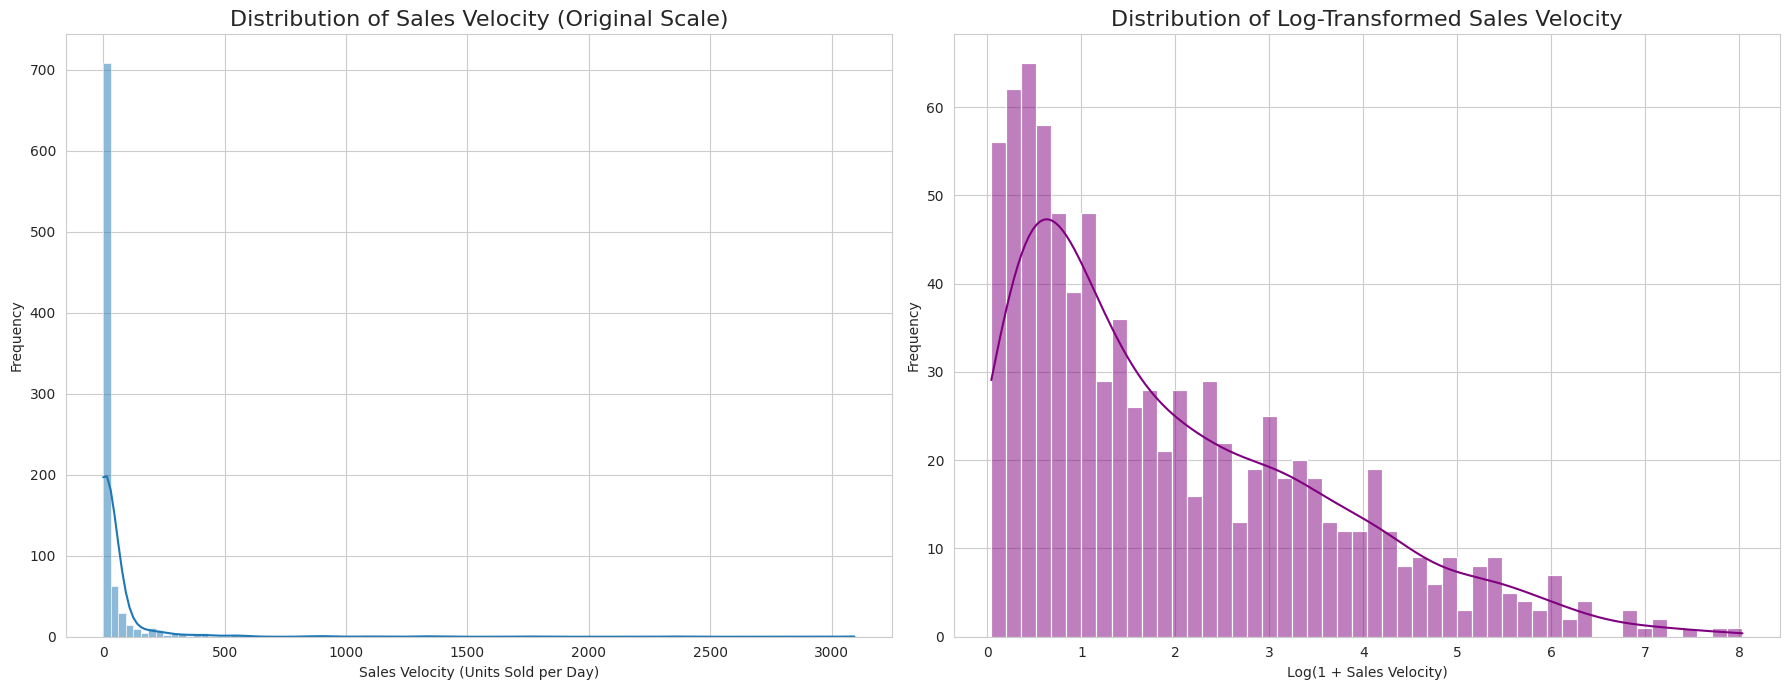

--- Summary Statistics for Sales Velocity ---
count    878.00
mean      43.89
std      181.98
min        0.04
25%        0.84
50%        3.38
75%       19.45
max     3093.00
Name: sales_velocity, dtype: float64


In [23]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Standard Distribution
sns.histplot(df_clean['sales_velocity'], bins=100, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Sales Velocity (Original Scale)', fontsize=16)
axes[0].set_xlabel('Sales Velocity (Units Sold per Day)')
axes[0].set_ylabel('Frequency')

# Plot 2: Log-Transformed Distribution
# We use np.log1p which calculates log(1 + x) to handle values of 0 safely.
log_sales_velocity = np.log1p(df_clean['sales_velocity'])
sns.histplot(log_sales_velocity, bins=50, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Distribution of Log-Transformed Sales Velocity', fontsize=16)
axes[1].set_xlabel('Log(1 + Sales Velocity)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics to complement the visuals
print("--- Summary Statistics for Sales Velocity ---")
print(df_clean['sales_velocity'].describe())

**Analysis of Target Variable:**
*   **Extreme Skewness:** The original distribution plot confirms our statistical findings. It is extremely right-skewed, with the vast majority of listings clustered near zero and a very long tail of high-velocity outliers. It's nearly impossible to discern any pattern from this raw scale.
*   **Log-Transformed View:** The log-transformed plot is far more insightful. It reveals a distribution that is much closer to normal, which is ideal for many regression models. This strongly indicates that we should use `log1p(sales_velocity)` as our target variable during model training.
*   **Statistical Confirmation:** The summary statistics reinforce this: the mean (43.89) is over 10 times larger than the median (3.38), a classic sign of being heavily influenced by extreme outliers.

#### 5.2. Univariate Analysis (Analyzing Individual Features)

Now we will examine the distributions of our most important predictor features one by one. This helps us understand their characteristics, such as central tendency, spread, and the presence of outliers.

##### Numerical Features: `price` and `volume_ml`

Let's start with our key numerical predictors. We'll use histograms to see their distributions and boxplots to identify outliers. Before we plot, we need to handle the missing `volume_ml` values we identified earlier. A good strategy is to fill them with the median, as it is robust to outliers.

Missing 'volume_ml' values filled with median: 100.55 ml


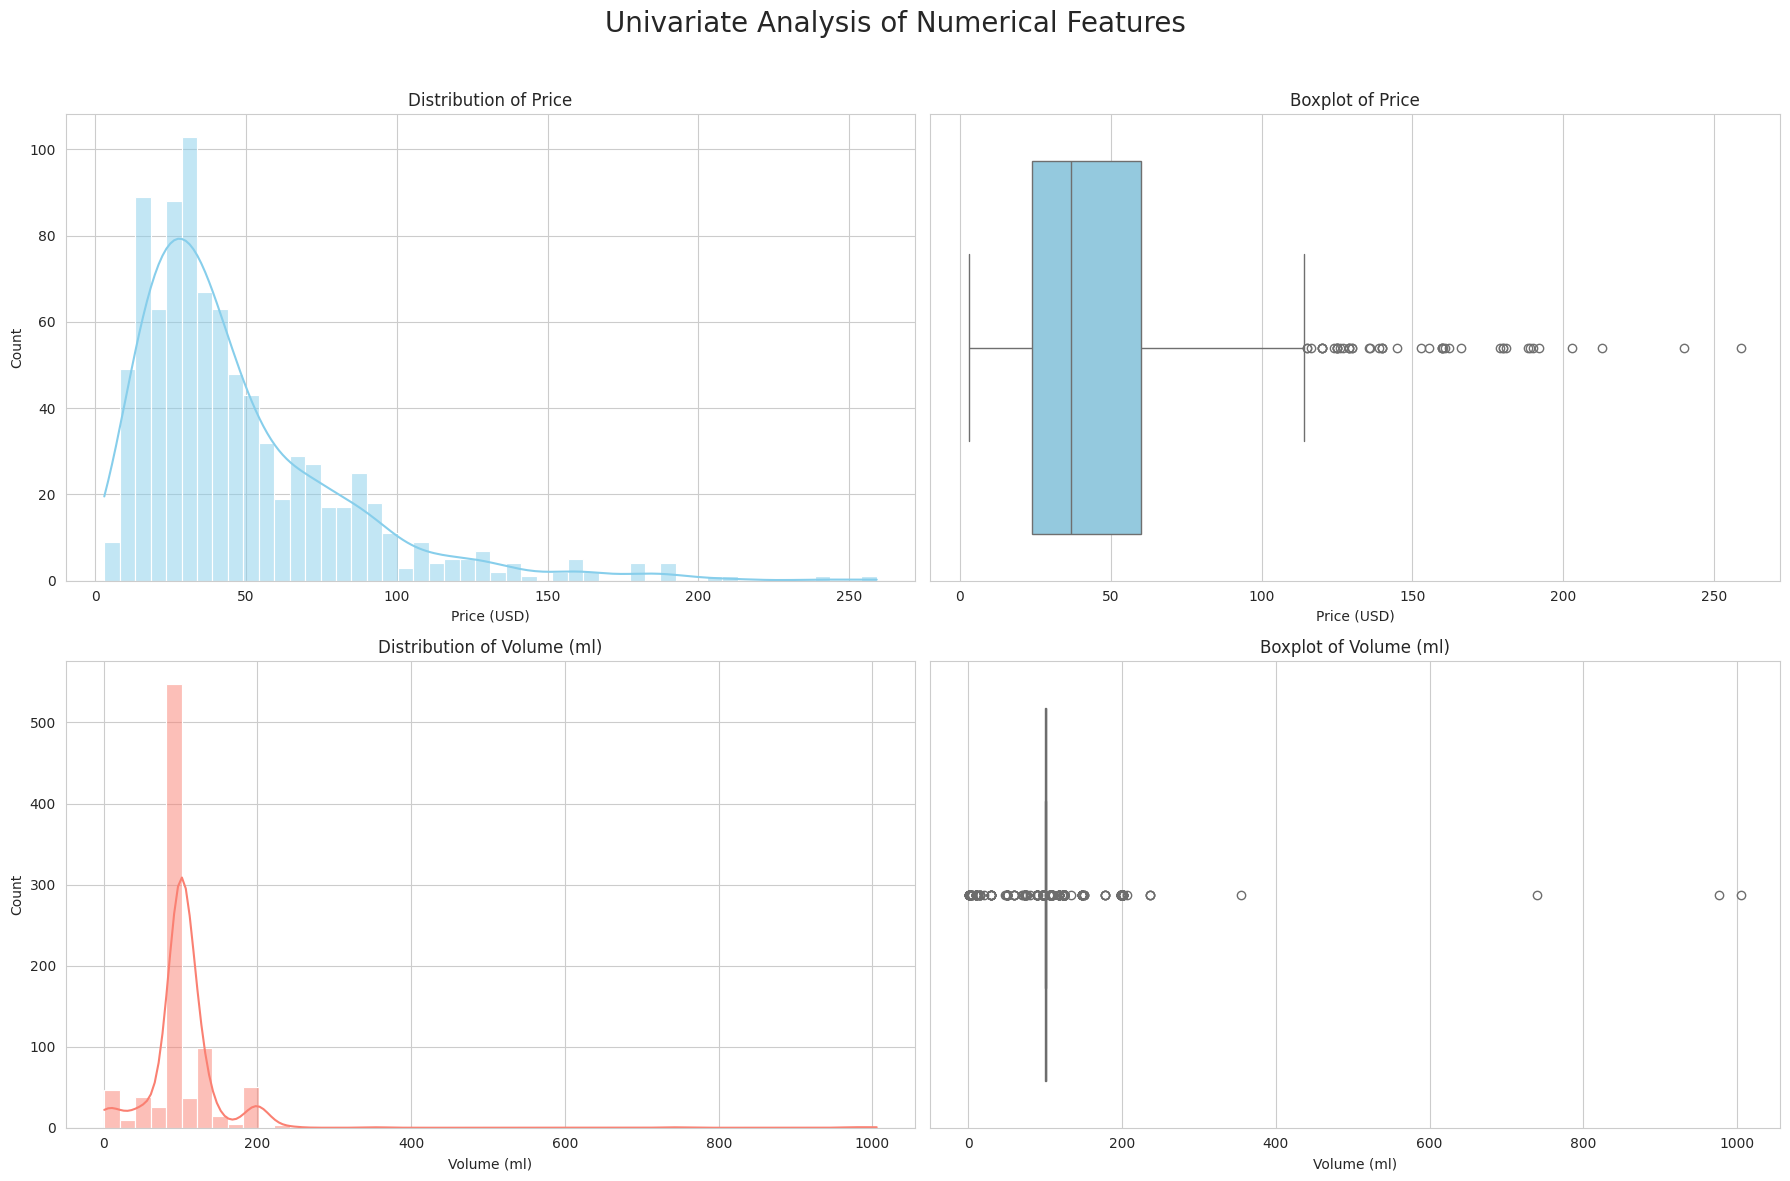

In [24]:
# Impute missing volume_ml values with the median
median_volume = df_clean['volume_ml'].median()
df_clean['volume_ml'].fillna(median_volume, inplace=True)
print(f"Missing 'volume_ml' values filled with median: {median_volume:.2f} ml")

# Set up the figure for a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Univariate Analysis of Numerical Features', fontsize=20)

# Plotting distribution for 'price'
sns.histplot(df_clean['price'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Price')
axes[0, 0].set_xlabel('Price (USD)')

# Plotting boxplot for 'price'
sns.boxplot(x=df_clean['price'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot of Price')
axes[0, 1].set_xlabel('Price (USD)')

# Plotting distribution for 'volume_ml'
sns.histplot(df_clean['volume_ml'], bins=50, kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribution of Volume (ml)')
axes[1, 0].set_xlabel('Volume (ml)')

# Plotting boxplot for 'volume_ml'
sns.boxplot(x=df_clean['volume_ml'], ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Boxplot of Volume (ml)')
axes[1, 1].set_xlabel('Volume (ml)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Analysis of Numerical Features:**

*   **`price`:**
    *   **Distribution:** The price is also right-skewed. Most perfumes are priced under \$50, with a long tail of more expensive, luxury items.
    *   **Outliers:** The boxplot clearly shows a significant number of outliers on the higher end, with listings priced above ~$125 being flagged. This is expected in a market with both standard and premium products. We will keep these for now as they represent legitimate high-end perfumes.

*   **`volume_ml`:**
    *   **Distribution:** The volume distribution is highly concentrated around the 100ml mark, which appears to be the standard bottle size. There are smaller peaks for sample sizes and larger format bottles.
    *   **Outliers:** The boxplot identifies several outliers, particularly those with very large volumes (e.g., > 400ml). These could be multi-packs or data entry errors and warrant closer inspection later.

##### Categorical Features: `brand`, `type`, and `country`

Next, let's examine the frequencies of our key categorical features. This will show us which categories are most common and highlight any potential class imbalance.

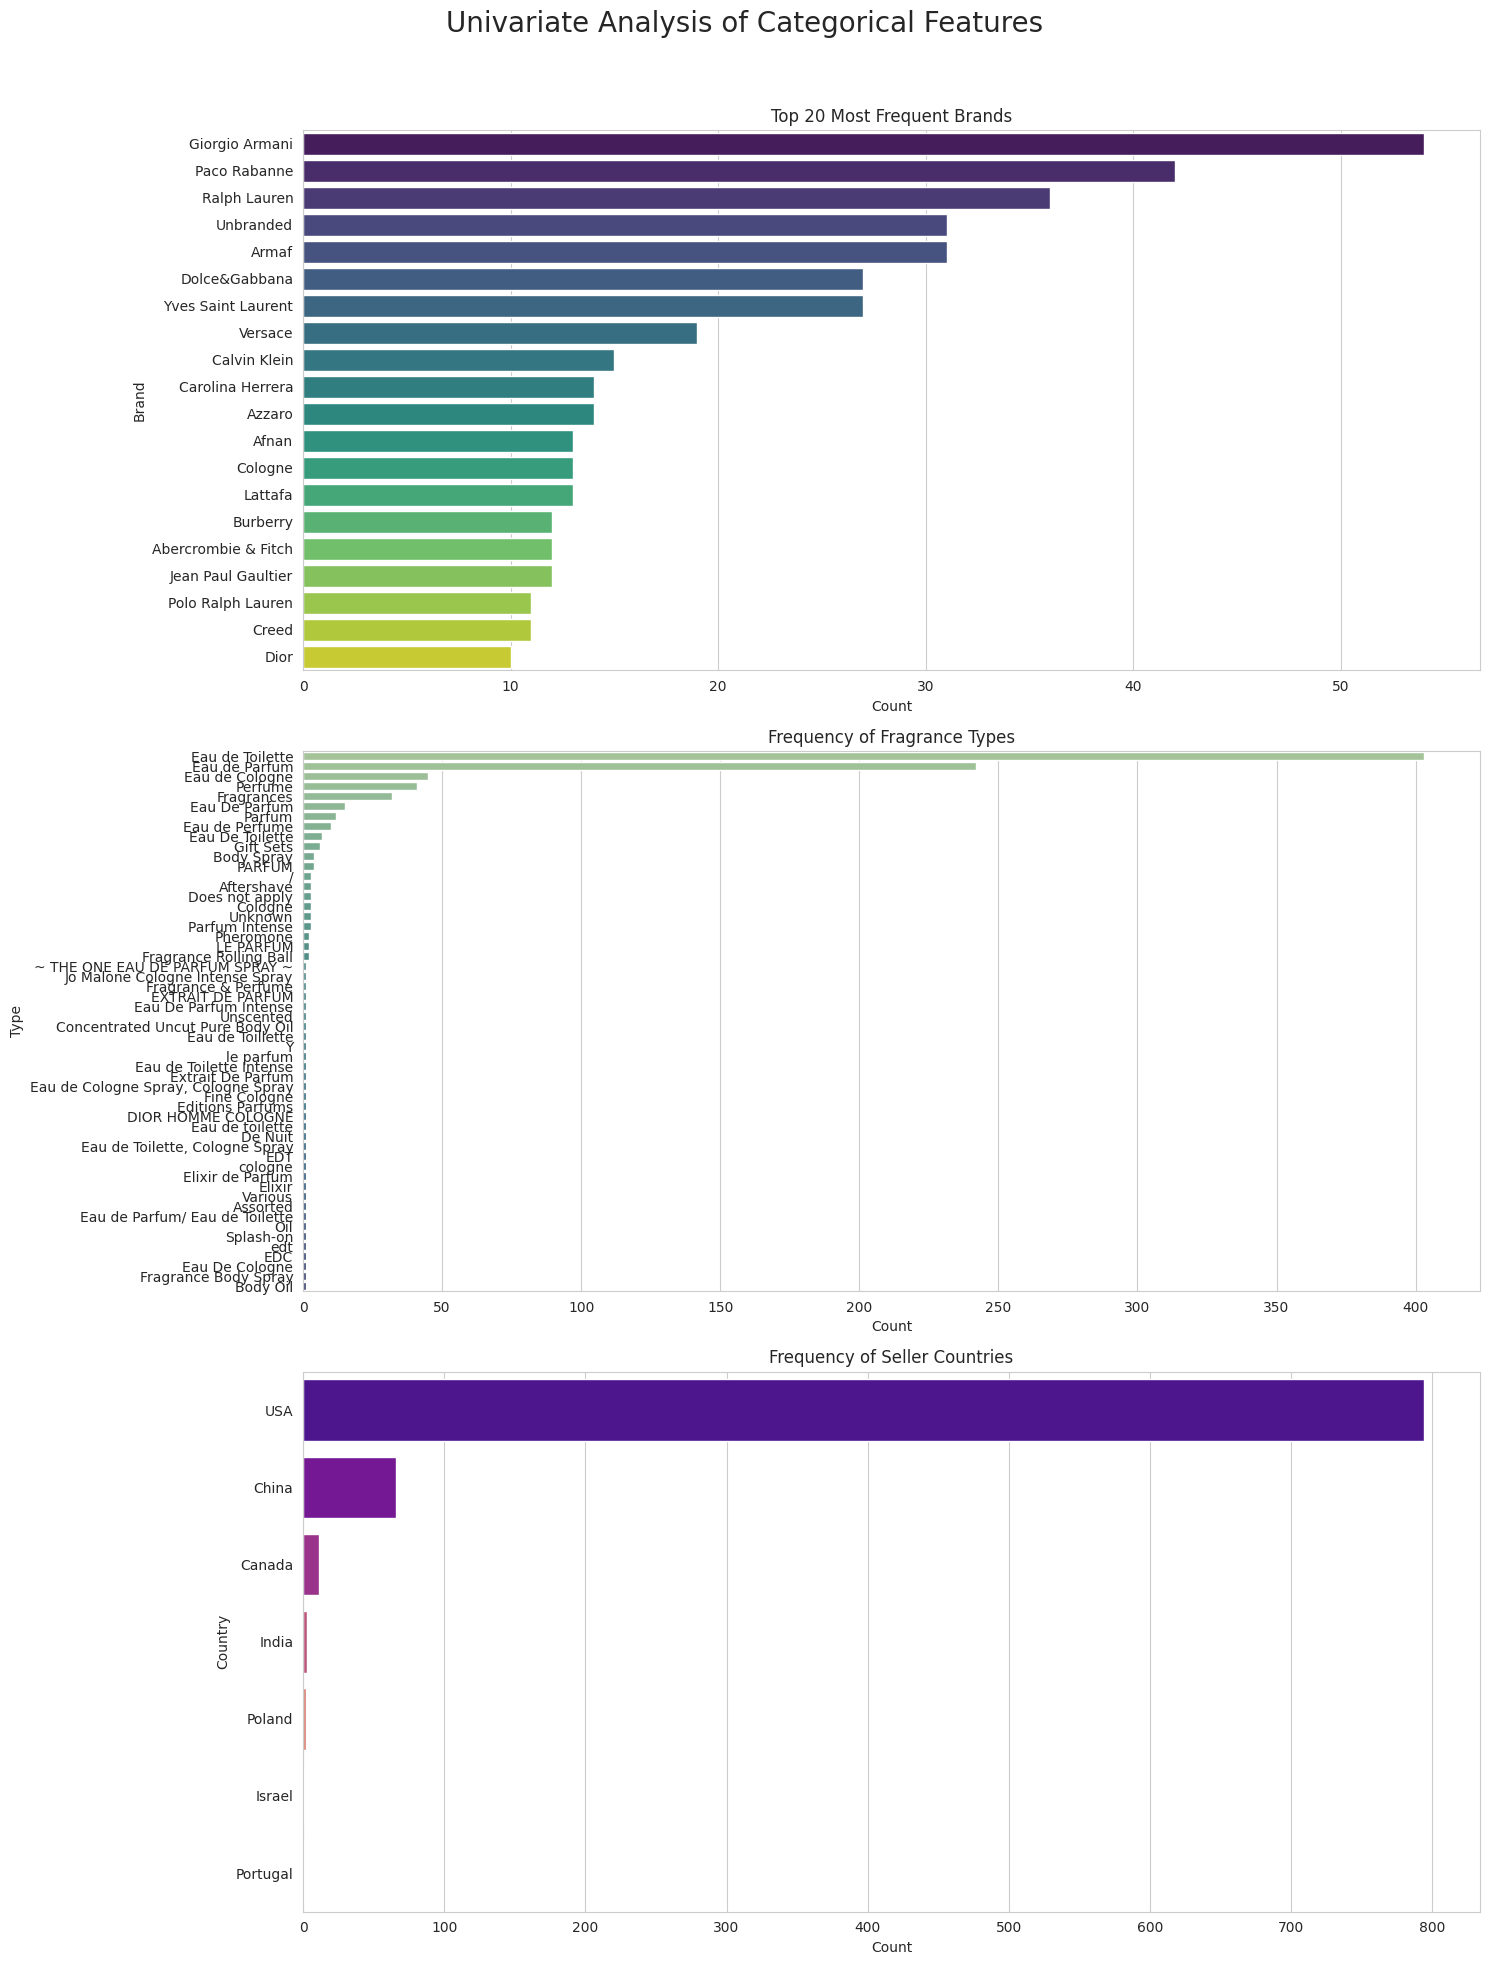

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Univariate Analysis of Categorical Features', fontsize=20)

# Plot for Top 20 Brands
brand_counts = df_clean['brand'].value_counts().nlargest(20)
sns.barplot(x=brand_counts.values, y=brand_counts.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Frequent Brands')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Brand')

# Plot for Fragrance Type
type_counts = df_clean['type'].value_counts()
sns.barplot(x=type_counts.values, y=type_counts.index, ax=axes[1], palette='crest')
axes[1].set_title('Frequency of Fragrance Types')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Type')

# Plot for Country
country_counts = df_clean['country'].value_counts()
sns.barplot(x=country_counts.values, y=country_counts.index, ax=axes[2], palette='plasma')
axes[2].set_title('Frequency of Seller Countries')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Country')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Analysis of Categorical Features:**

*   **`brand`:**
    *   **Dominance of Key Players:** The market is led by a few major brands. 'Giorgio Armani', 'Paco Rabanne', and 'Ralph Lauren' are the most frequently listed. 'Unbranded' also has a strong presence, highlighting a significant segment of generic or clone fragrances.
    *   **Long-Tail Distribution:** The steep drop-off in frequency after the top 10 brands shows a classic long-tail distribution. This suggests that for modeling, we should group the less frequent brands into an 'Other' category to prevent our model from overfitting on rare occurrences.

*   **`type`:**
    *   **Market Standard:** 'Eau de Toilette' is by far the most common fragrance type, followed by 'Eau de Parfum'. This aligns with general consumer market trends.
    *   **Cleaning Opportunity:** The plot reveals many messy, inconsistent, and rare categories (e.g., `LE PARFUM`, `~ THE ONE EAU DE PARFUM SPRAY ~`). This presents a clear opportunity for a data cleaning function to standardize these types (e.g., group all 'Parfum' variations together) before modeling.

*   **`country`:**
    *   **USA Dominance:** The seller landscape is overwhelmingly dominated by listings from the `USA`.
    *   **Imbalance:** The severe imbalance means that our model will learn much more about the US market than any other. This is a key limitation of the dataset to be aware of.

### 5.3. Bivariate Analysis (Feature vs. Target)

In this section, we'll investigate the relationship between our key predictor variables and the `sales_velocity` target. This will help us identify the strongest signals for our model.

##### Numerical Features vs. Sales Velocity

Let's start by visualizing the impact of `price` and `volume_ml` on sales. We will also engineer a new, powerful feature: `price_per_ml`.

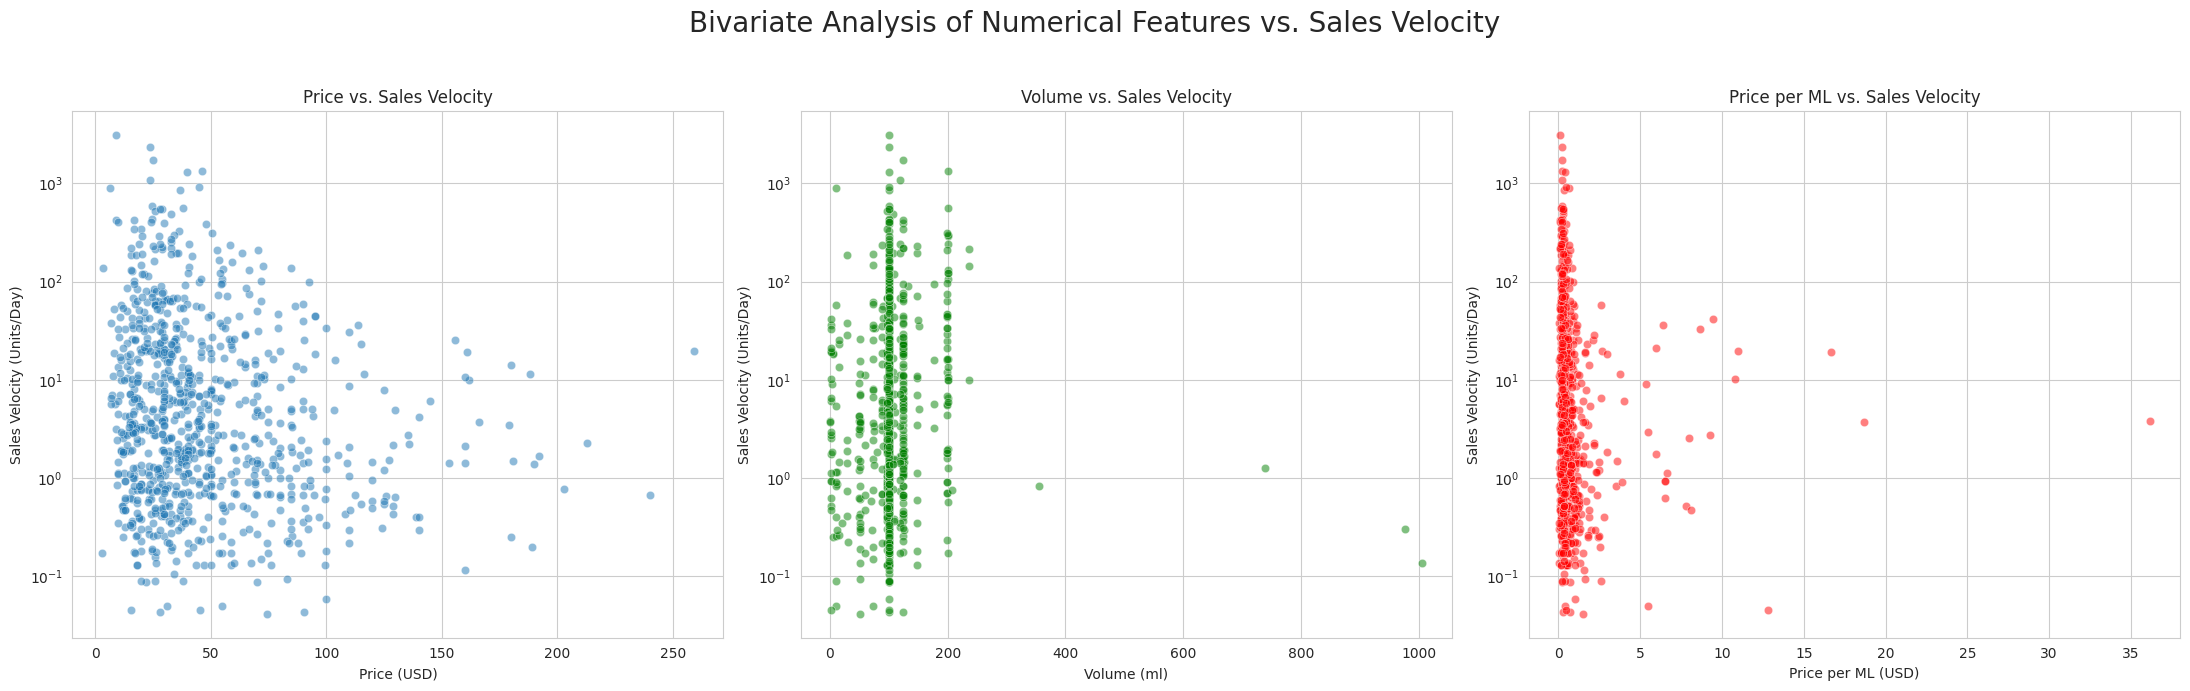

In [26]:
# Engineer the 'price_per_ml' feature for a normalized value comparison
# We'll replace potential division by zero or infinity with NaN, then drop them for the plot
df_clean['price_per_ml'] = df_clean['price'] / df_clean['volume_ml']
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set up the figure for the plots
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Bivariate Analysis of Numerical Features vs. Sales Velocity', fontsize=20)

# Plot 1: Price vs. Sales Velocity
sns.scatterplot(data=df_clean, x='price', y='sales_velocity', ax=axes[0], alpha=0.5)
axes[0].set_title('Price vs. Sales Velocity')
axes[0].set_ylabel('Sales Velocity (Units/Day)')
axes[0].set_xlabel('Price (USD)')
axes[0].set_yscale('log') # Log scale for better visibility

# Plot 2: Volume vs. Sales Velocity
sns.scatterplot(data=df_clean, x='volume_ml', y='sales_velocity', ax=axes[1], alpha=0.5, color='green')
axes[1].set_title('Volume vs. Sales Velocity')
axes[1].set_ylabel('Sales Velocity (Units/Day)')
axes[1].set_xlabel('Volume (ml)')
axes[1].set_yscale('log')

# Plot 3: Price per ML vs. Sales Velocity
sns.scatterplot(data=df_clean.dropna(subset=['price_per_ml']), x='price_per_ml', y='sales_velocity', ax=axes[2], alpha=0.5, color='red')
axes[2].set_title('Price per ML vs. Sales Velocity')
axes[2].set_ylabel('Sales Velocity (Units/Day)')
axes[2].set_xlabel('Price per ML (USD)')
axes[2].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Analysis of Numerical Features vs. Target:**

*   **`price` vs. `sales_velocity`:** This plot strongly confirms our hypothesis. There is a clear negative relationship: the highest sales velocities (above 100 units/day) occur almost exclusively for products priced under $50. As price increases, the potential for high-velocity sales diminishes significantly.
*   **`volume_ml` vs. `sales_velocity`:** The relationship here is less direct. The highest velocities are clustered around the standard 100ml size. This doesn't necessarily mean 100ml bottles sell faster, but rather that the most popular products are typically offered in this standard size. Very large or very small (sample) sizes tend to have lower sales velocity.
*   **`price_per_ml` vs. `sales_velocity`:** This normalized feature tells a powerful story. The highest sales velocities are concentrated where the `price_per_ml` is very low (less than $1/ml). This reinforces that **value for money** is a massive driver of sales volume on this platform.

##### Categorical Features vs. Sales Velocity

Now, let's explore how categorical features like `brand`, `type`, and `country` influence sales velocity. We'll use violin plots, which are excellent for comparing distributions across different categories.

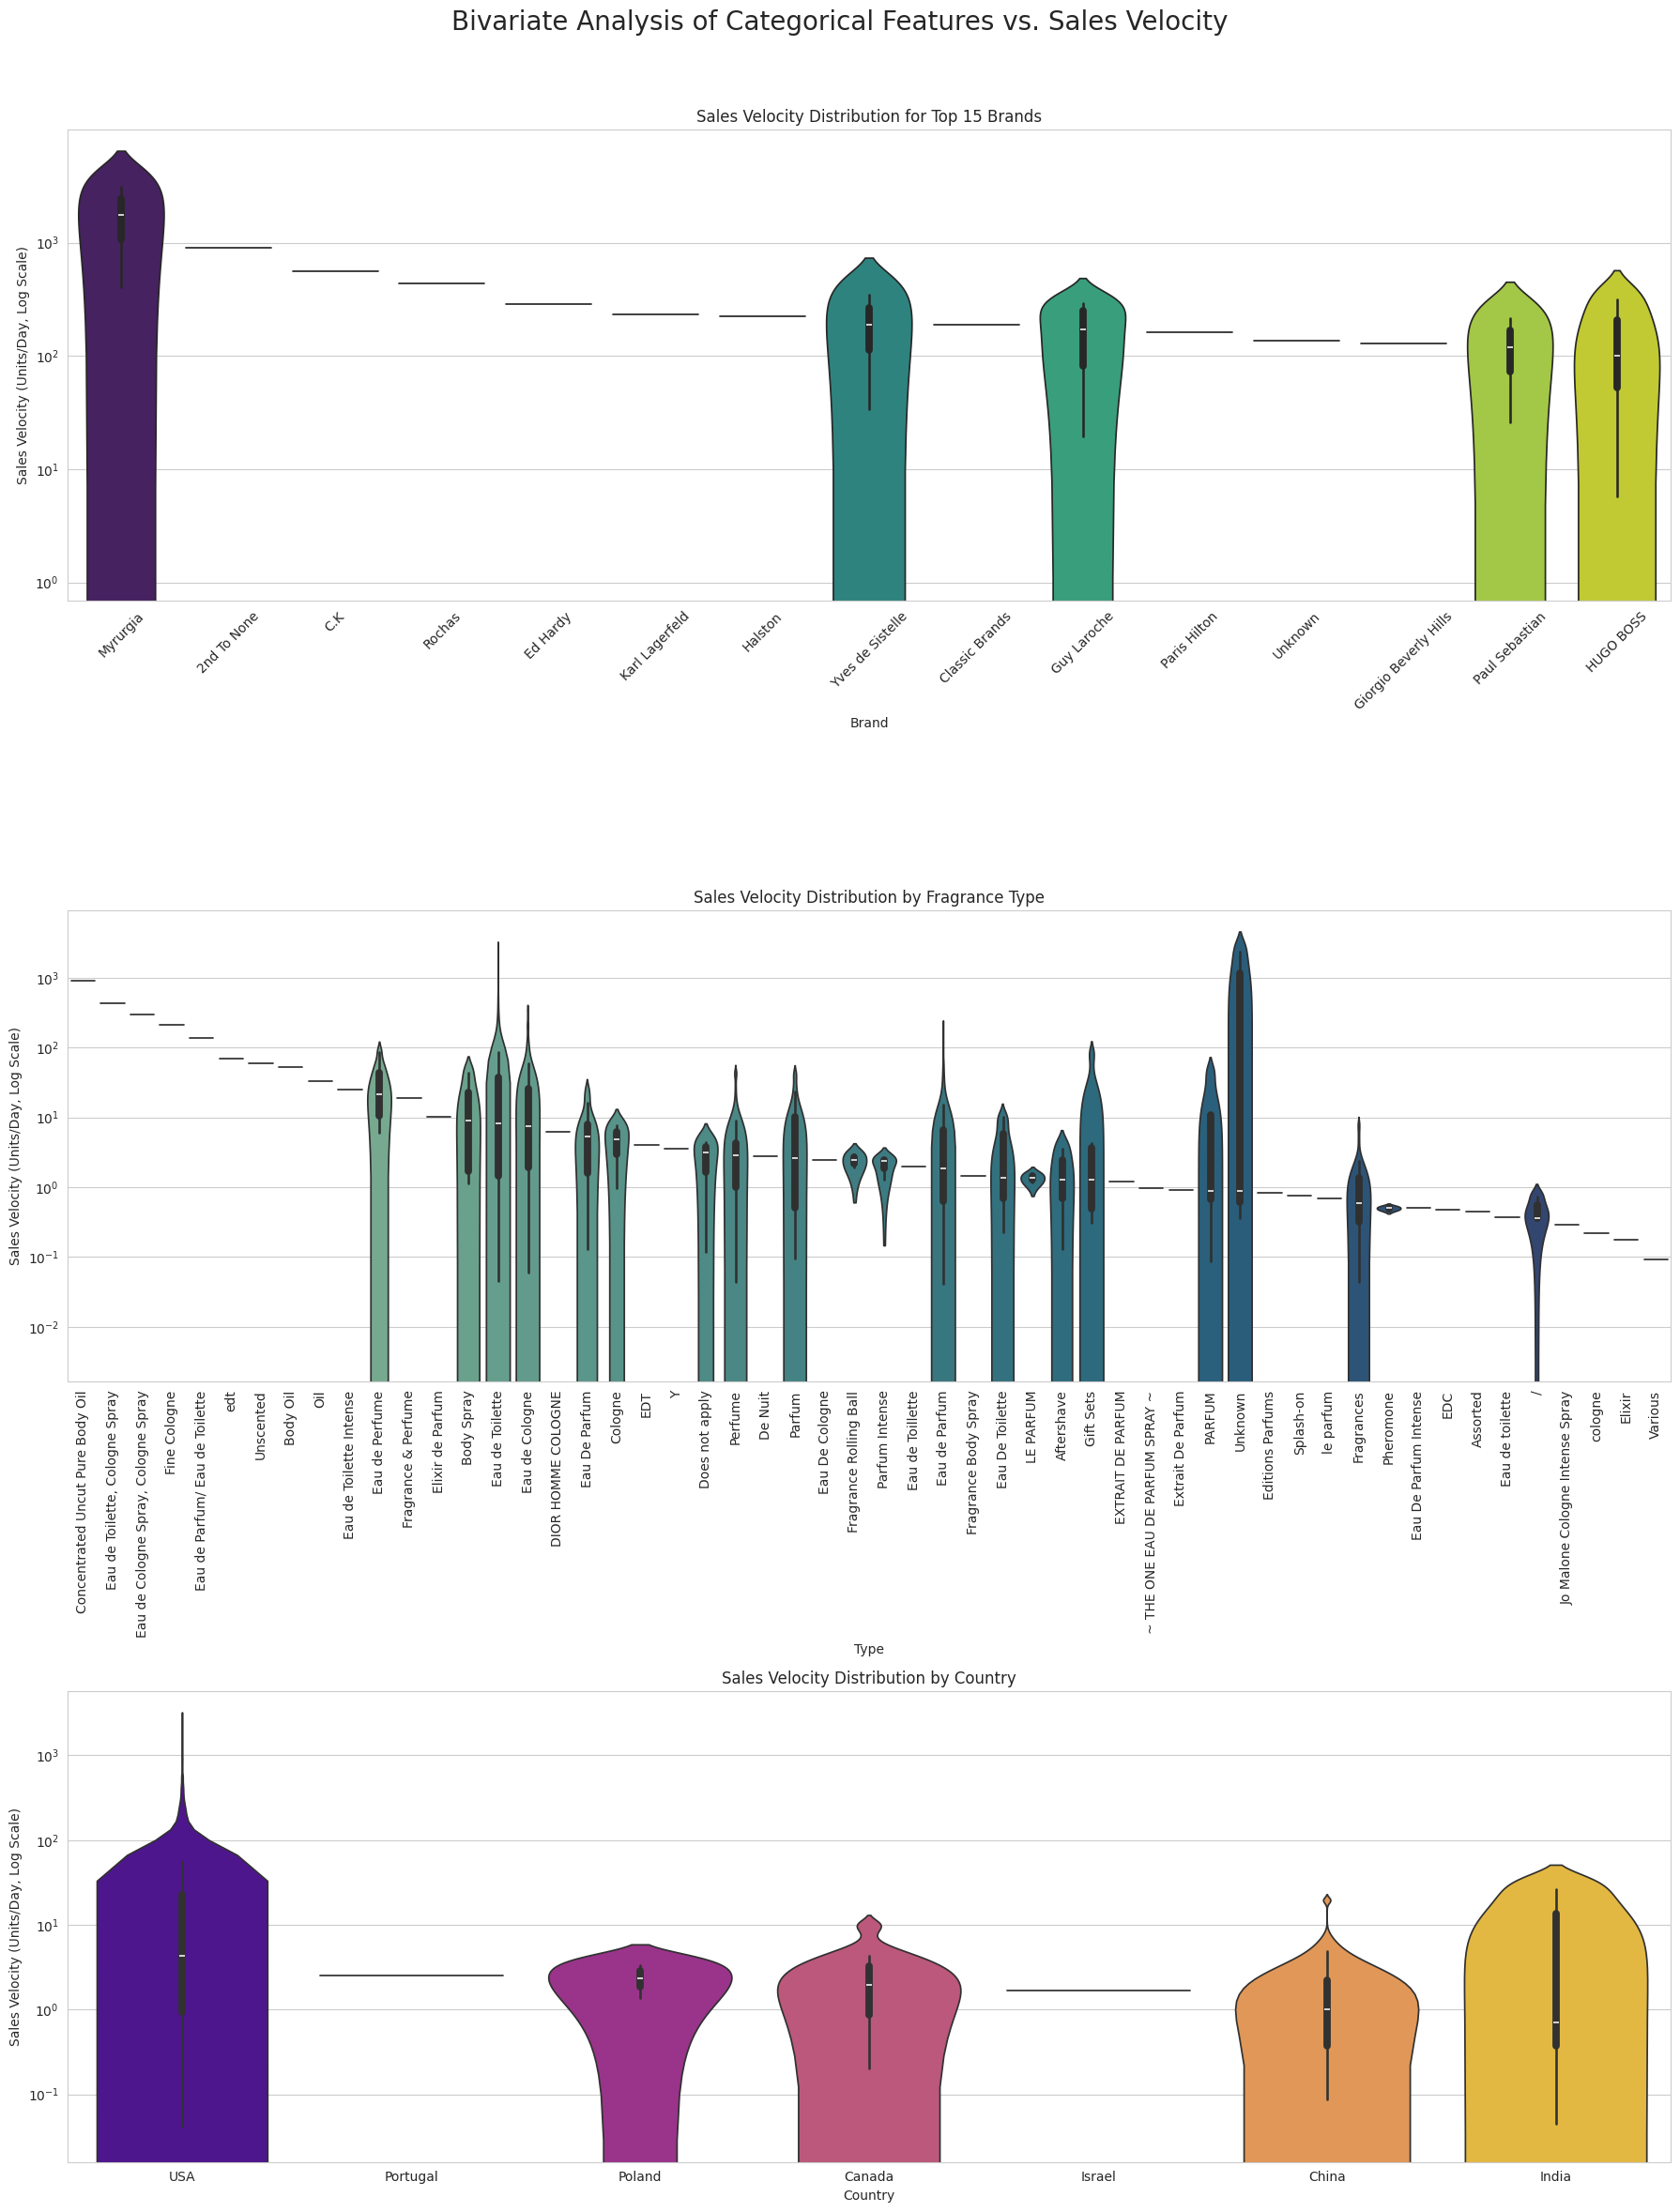

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(18, 24))
fig.suptitle('Bivariate Analysis of Categorical Features vs. Sales Velocity', fontsize=20)

# --- Plot 1: Top 15 Brands vs. Sales Velocity ---
# Get the order of top brands by median sales velocity
top_15_brands_order = df_clean.groupby('brand')['sales_velocity'].median().nlargest(15).index
df_top_brands = df_clean[df_clean['brand'].isin(top_15_brands_order)]

sns.violinplot(data=df_top_brands, x='brand', y='sales_velocity', ax=axes[0], order=top_15_brands_order, palette='viridis')
axes[0].set_title('Sales Velocity Distribution for Top 15 Brands')
axes[0].set_ylabel('Sales Velocity (Units/Day, Log Scale)')
axes[0].set_xlabel('Brand')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Type vs. Sales Velocity ---
type_order = df_clean.groupby('type')['sales_velocity'].median().sort_values(ascending=False).index
sns.violinplot(data=df_clean, x='type', y='sales_velocity', ax=axes[1], order=type_order, palette='crest')
axes[1].set_title('Sales Velocity Distribution by Fragrance Type')
axes[1].set_ylabel('Sales Velocity (Units/Day, Log Scale)')
axes[1].set_xlabel('Type')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)


# --- Plot 3: Country vs. Sales Velocity ---
country_order = df_clean.groupby('country')['sales_velocity'].median().sort_values(ascending=False).index
sns.violinplot(data=df_clean, x='country', y='sales_velocity', ax=axes[2], order=country_order, palette='plasma')
axes[2].set_title('Sales Velocity Distribution by Country')
axes[2].set_ylabel('Sales Velocity (Units/Day, Log Scale)')
axes[2].set_xlabel('Country')
axes[2].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Analysis of Categorical Features vs. Target:**

*   **`brand` vs. `sales_velocity`:** The violin plots give a much richer view than simple averages.
    *   **High-Velocity Outliers:** Brands like 'Myrurgia' and '2nd To None' show an incredible range, with some listings achieving extreme sales velocities. These appear to be outliers that pull the average up.
    *   **Consistent Performers:** More mainstream brands like 'Yves de Sistelle', 'Guy Laroche', and 'HUGO BOSS' show a dense distribution at a moderately high velocity. This suggests they are reliable, high-volume sellers.
    *   The `Unknown` and `Classic Brands` categories also show potential for high sales, indicating that a strong value proposition can sometimes overcome brand recognition.

*   **`type` vs. `sales_velocity`:** The plot is very noisy due to the large number of inconsistent categories. However, we can still see that types like 'Concentrated Uncut Pure Body Oil' and some 'Eau de Toilette' variations have the highest velocity ceilings. This confirms that a major data cleaning/grouping task on the `type` column will be essential before modeling.

*   **`country` vs. `sales_velocity`:** This plot powerfully confirms our hypothesis. The distribution of `sales_velocity` for listings from the **USA** is dramatically higher and wider than for any other country. Sellers from China and India, while present, operate at a much lower sales velocity. `country` will be a very important feature.

### 5.4. Multivariate Analysis (Feature vs. Feature)

Finally, let's examine the relationships between our predictor variables. This helps us understand interactions and check for multicollinearity. The best tool for this is a correlation heatmap.

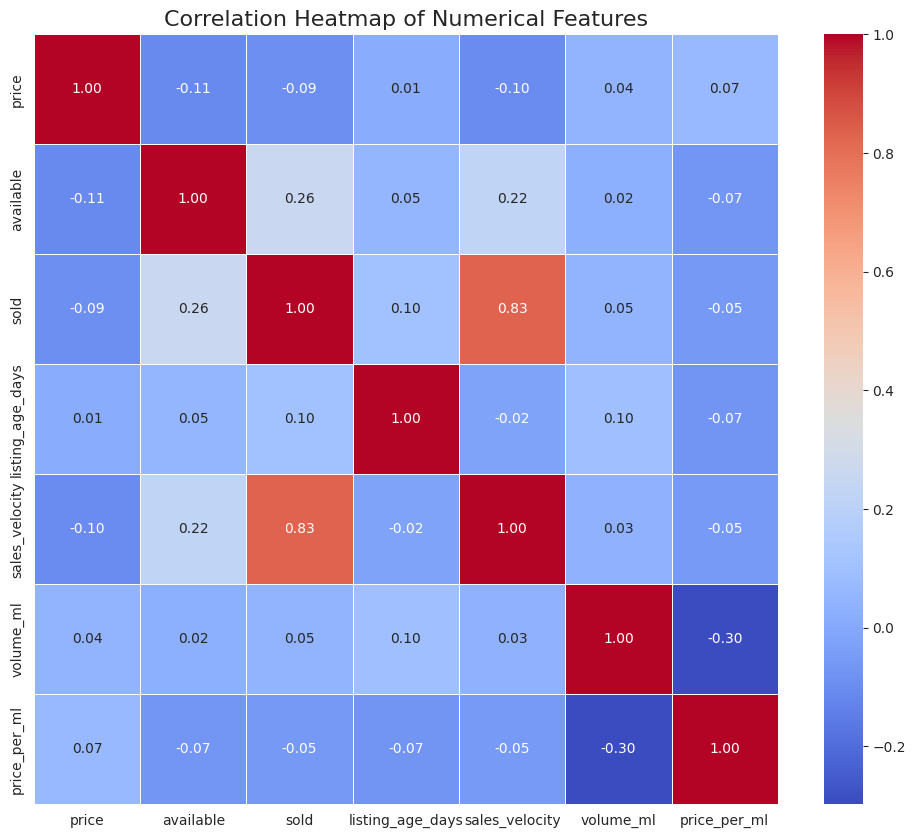

In [28]:
# Select only the numerical columns for the correlation matrix
numerical_cols = ['price', 'available', 'sold', 'listing_age_days', 'sales_velocity', 'volume_ml', 'price_per_ml']
corr_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

**Analysis of the Correlation Heatmap:**

The heatmap reveals several important relationships and confirms our data leakage concerns.

*   **Strongest Correlations with Target:**
    *   As expected, `sold` has a very high positive correlation (0.83) with `sales_velocity`. **This is a mathematical artifact, not a predictive insight.** Because `sold` is part of the target calculation, using it as a feature would be a severe case of data leakage.
    *   `available` has a slight positive correlation (0.22). This is also a form of leakage, as stock levels are related to sales.
    *   `price` has a slight negative correlation (-0.10), which is weaker than expected but still present. The relationship is likely non-linear, as seen in the scatter plot.

*   **Feature-Feature Correlations:**
    *   There is a moderate negative correlation between `price` and `available` (-0.11), suggesting more expensive items are stocked in lower quantities.
    *   `volume_ml` and `price_per_ml` have a moderate negative correlation (-0.30), which makes sense: larger bottles typically have a lower cost per milliliter.

*   **Actionable Insight for Modeling:**
    *   **To prevent data leakage, we must drop the `sold` and `available` columns before training our model.**
    *   The other numerical features do not show strong multicollinearity with each other, so they can be safely used together in most models.

**Conclusion of EDA:**
Our comprehensive EDA is complete. We've confirmed that the best predictors for sales velocity will be `price` (especially `price_per_ml`), `brand`, `country`, and a cleaned version of `type`. We have also identified the need to log-transform our target and have made a critical decision to drop columns that would cause data leakage. We are now ready to move on to the final preprocessing and modeling stage.